In [1]:
!nvidia-smi

Mon Sep 23 11:55:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        On  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               2W /  50W |      5MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

data normalization

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing with mean and std of 0.5
])

Download and loading training data using torchvision

In [4]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:08<00:00, 3249665.15it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 509144.34it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2080801.47it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1408681.95it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Download and loading testing data

In [5]:
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

boilerplate autoencoder

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input is 28x28 image
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),  # Compressing to latent space of size 12
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),  # Output should be same size as input
            nn.Tanh()  # Output values between -1 and 1 due to normalization
        )
    
    def forward(self, x):
        # Flatten image to a vector (batch_size, 784)
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        # Reshape back to image dimensions (batch_size, 1, 28, 28)
        x = x.view(-1, 1, 28, 28)
        return x


### Intermission

In [8]:
# Initialize the model, define loss function and optimizer

model = Autoencoder()
criterion = nn.MSELoss() # MSE for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training

In [9]:
epochs = 10

for epoch in range(epochs):
    for data in train_loader:
        img, _ = data

        # Forward pass
        output = model(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0725
Epoch [2/10], Loss: 0.0572
Epoch [3/10], Loss: 0.0663
Epoch [4/10], Loss: 0.0675
Epoch [5/10], Loss: 0.0705
Epoch [6/10], Loss: 0.0608
Epoch [7/10], Loss: 0.0623
Epoch [8/10], Loss: 0.0589
Epoch [9/10], Loss: 0.0561
Epoch [10/10], Loss: 0.0734


Testing

In [12]:
# Switching model to evaluation mode
model.eval()

test_iter = iter(test_loader)
images, _ = next(test_iter)

# Reconstruct the images
with torch.no_grad():
    reconstructed = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9913272].


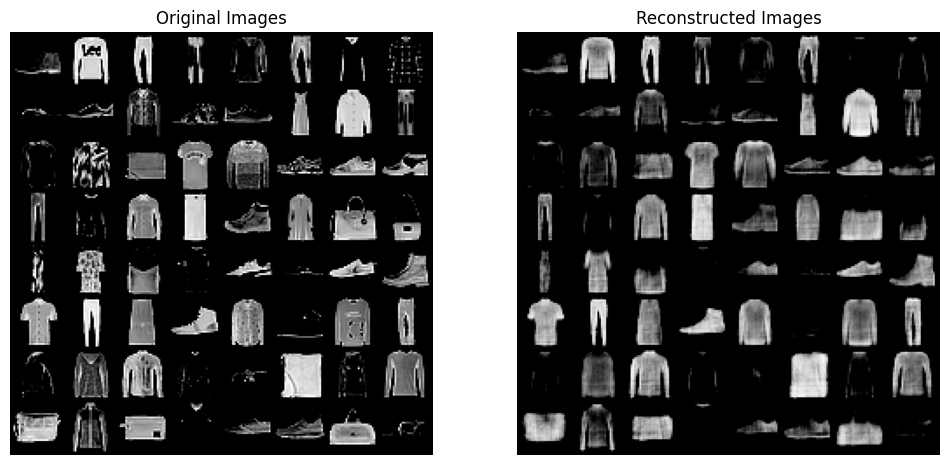

In [13]:
# Visualize original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original images
axes[0].imshow(utils.make_grid(images, nrow=8).permute(1, 2, 0).numpy())
axes[0].set_title('Original Images')
axes[0].axis('off')

# Reconstructed images
axes[1].imshow(utils.make_grid(reconstructed, nrow=8).permute(1, 2, 0).numpy())
axes[1].set_title('Reconstructed Images')
axes[1].axis('off')

plt.show()